In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import multiclass_helper as MH
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Generamos Dataset de tres clases

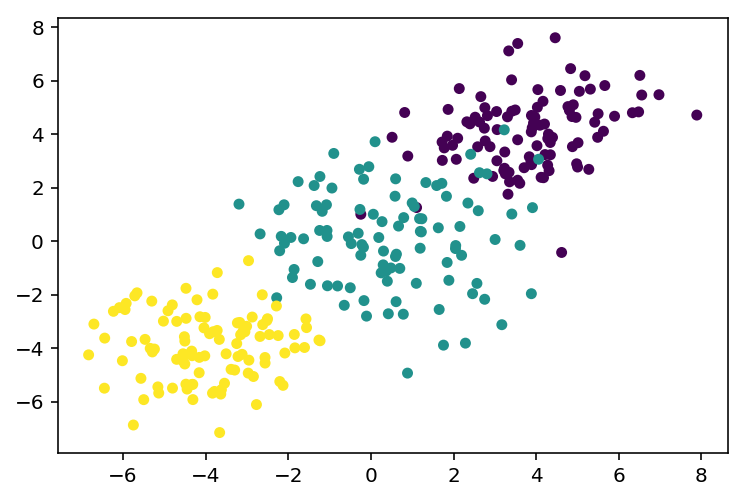

In [198]:
N = 100
mu_1 = [4, 4]
sigma_1 = [[  2,0.8],
           [0.8,  2]]

mu_2 = [0, 0]
sigma_2 = [[  3,  0],
           [  0,  3]]

mu_3 = [-4, -4]
sigma_3 = [[  2,  0],
           [  0,  2]]

mu_4 = [4, -2]
sigma_4 = [[  1,  0],
           [  0,  1]]

mu_5 = [-10, 2]
sigma_5 = [[  10,  0],
           [  0,  1]]


rvs = [
        [mu_1, sigma_1, N], 
        [mu_2, sigma_2, N],
        [mu_3, sigma_3, N],
        #[mu_4, sigma_4, N],
        #[mu_5, sigma_5, N]
      ]
X, y = MH.generate_dataset(rvs)
enc = OneHotEncoder(handle_unknown='ignore')
y_cat = enc.fit_transform(y.reshape(-1, 1))
plt.scatter(X[:,0], X[:,1], c=y, s=20)
plt.show()

In [4]:
y_cat #Sparse Matrix

<300x3 sparse matrix of type '<class 'numpy.float64'>'
	with 300 stored elements in Compressed Sparse Row format>

In [5]:
print(y_cat[0:5]) # Sparse representation

  (0, 0)	1.0
  (1, 0)	1.0
  (2, 0)	1.0
  (3, 0)	1.0
  (4, 0)	1.0


# Dividimos en train y test set

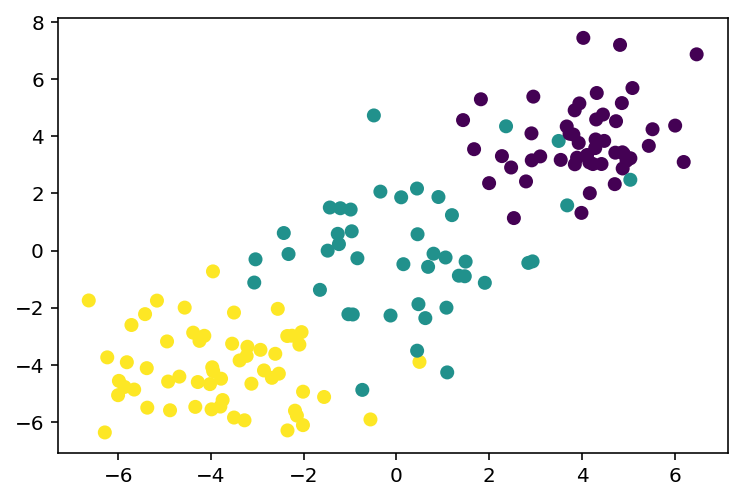

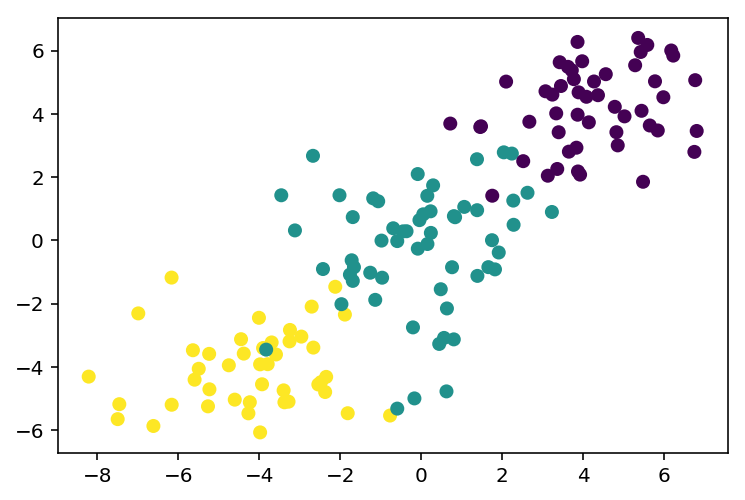

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
y_train_cat = enc.fit_transform(y_train.reshape(-1, 1)).toarray()
y_test_cat = enc.fit_transform(y_test.reshape(-1, 1)).toarray()
plt.scatter(X_train[:,0], X_train[:,1], c=y_train)
plt.show()
plt.scatter(X_test[:,0], X_test[:,1], c=y_test)
plt.show()

# One vs Rest

Entrenamos tantos modelos de regresión logística como clases tengo. Se calcula una solución de la clase contra todo el resto de las clases

## Regresión Logística

### Definimos un modelo para cada clase

### Entrenamos cada modelo por separado
La función de costo es simplemente la entropia binaria para cada clase

$J_i = - [p_i  \log(\hat{p}_i) + (1-p_i) \log(1-\hat{p}_i)]$  

donde: 
- $p_i$ solo puede valer 1 o 0. Vale 1 si pertenece a la clase $i$'esima, y 0 si no pertenece
- $\hat{p}_i$ es la estimación de la probabilidad de que $X_i$ pertenezca a la clase

$\hat{y}_i = w_{0, i} + w_{1, i} X_0 + w_{2, i} X_1 $  

$\large \hat{p}_i = \frac{1}{1+e^{-\hat{y}_i}}$

$X_i$'s son los features

In [121]:
from sklearn.linear_model import SGDClassifier
lr = 0.04
models_vs_rest = []
for i in range(y_train_cat.shape[1]):
    model_vs_rest=SGDClassifier(loss='log',penalty=None,max_iter=1000,tol=0.000001,eta0=lr)
    model_vs_rest.fit(X_train, y_train_cat[:,i])
    models_vs_rest.append(model_vs_rest)

In [122]:
for i in range(y_train_cat.shape[1]):
    print(models_vs_rest[i].score(X,y_cat[:,i].toarray()))

0.9633333333333334
0.47333333333333333
0.97


In [159]:
def predict_proba_one_rest(X, verbose=1):
    proba = list()
    for model in models_vs_rest:
        out = model.predict_proba(X)[:,1]
        proba.append(out)
    return np.array(proba).T

def evaluate_proba_one_rest(X, y):
    return np.sum(np.argmax(predict_proba_one_rest(X), axis = 1) == y)/len(y)

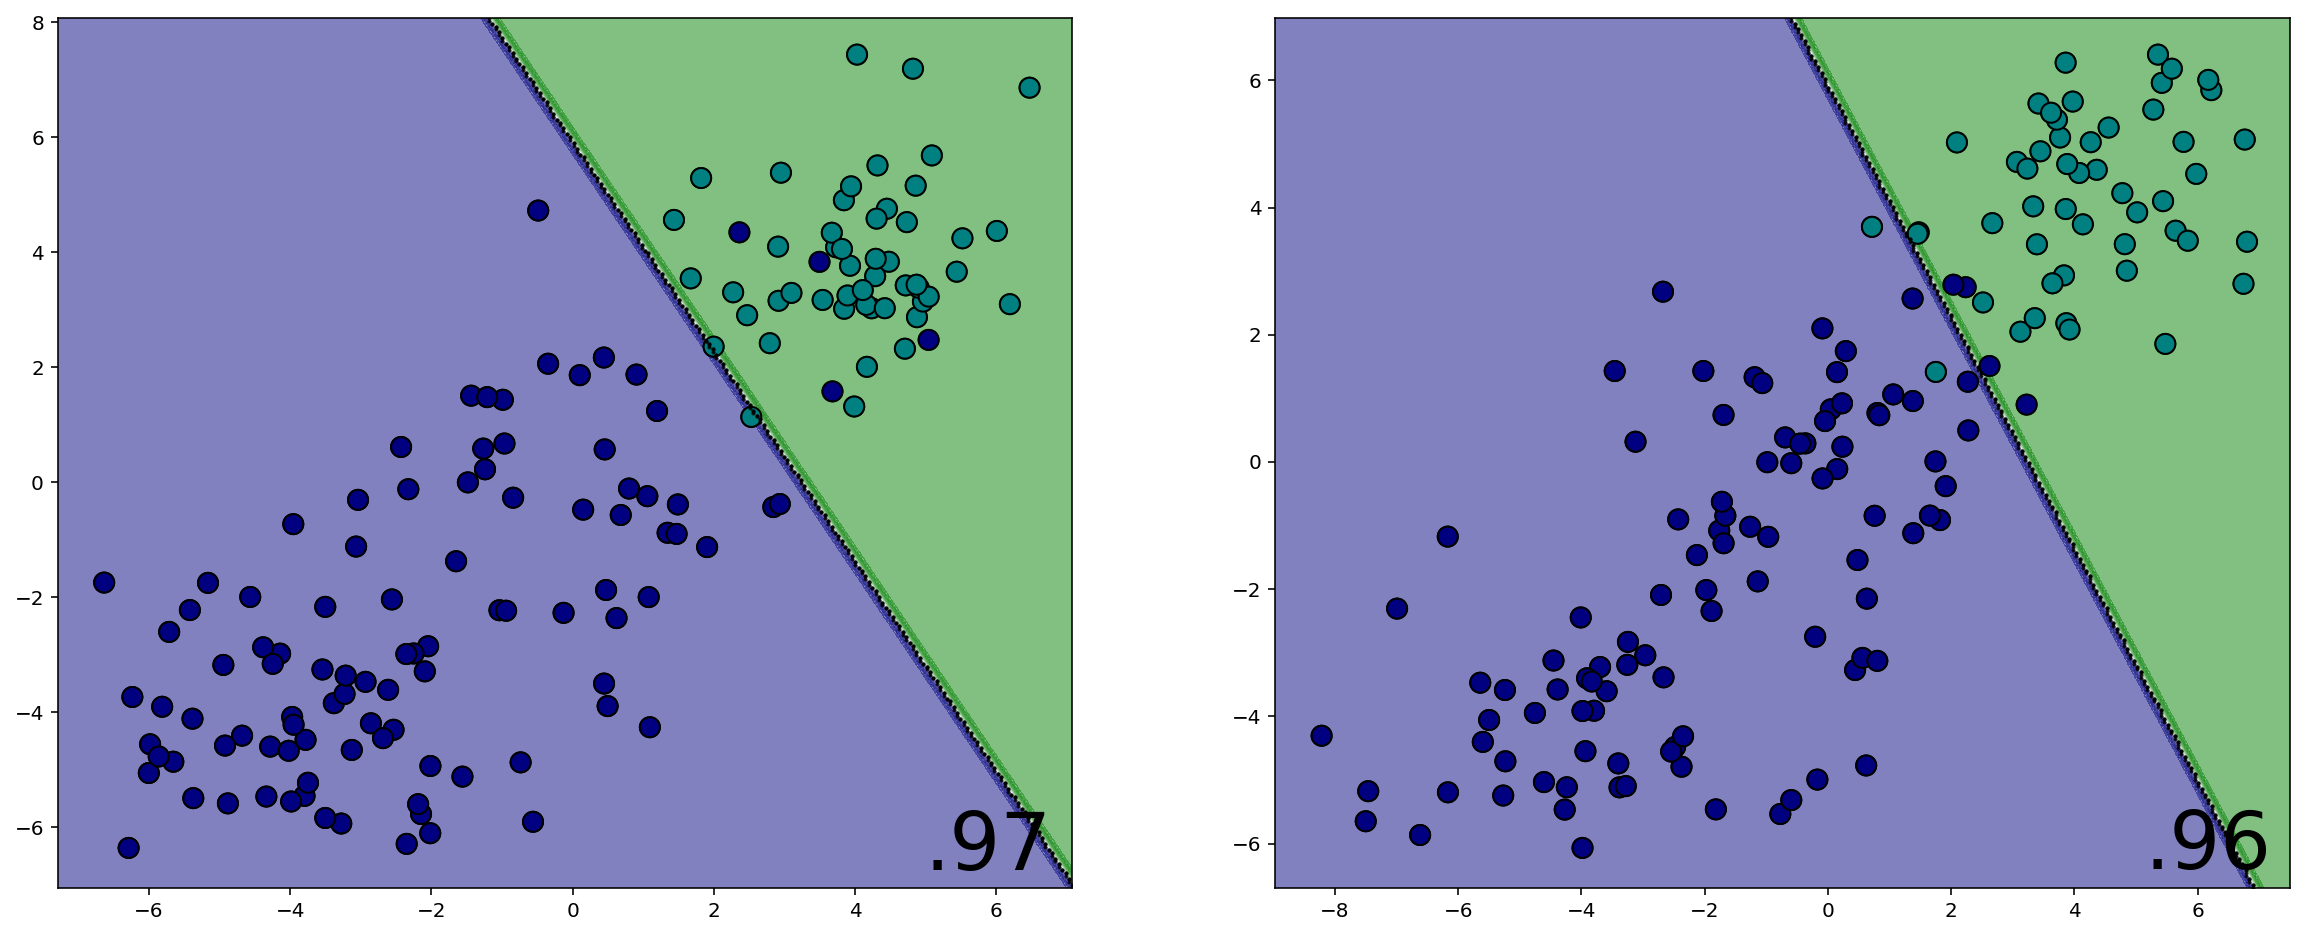

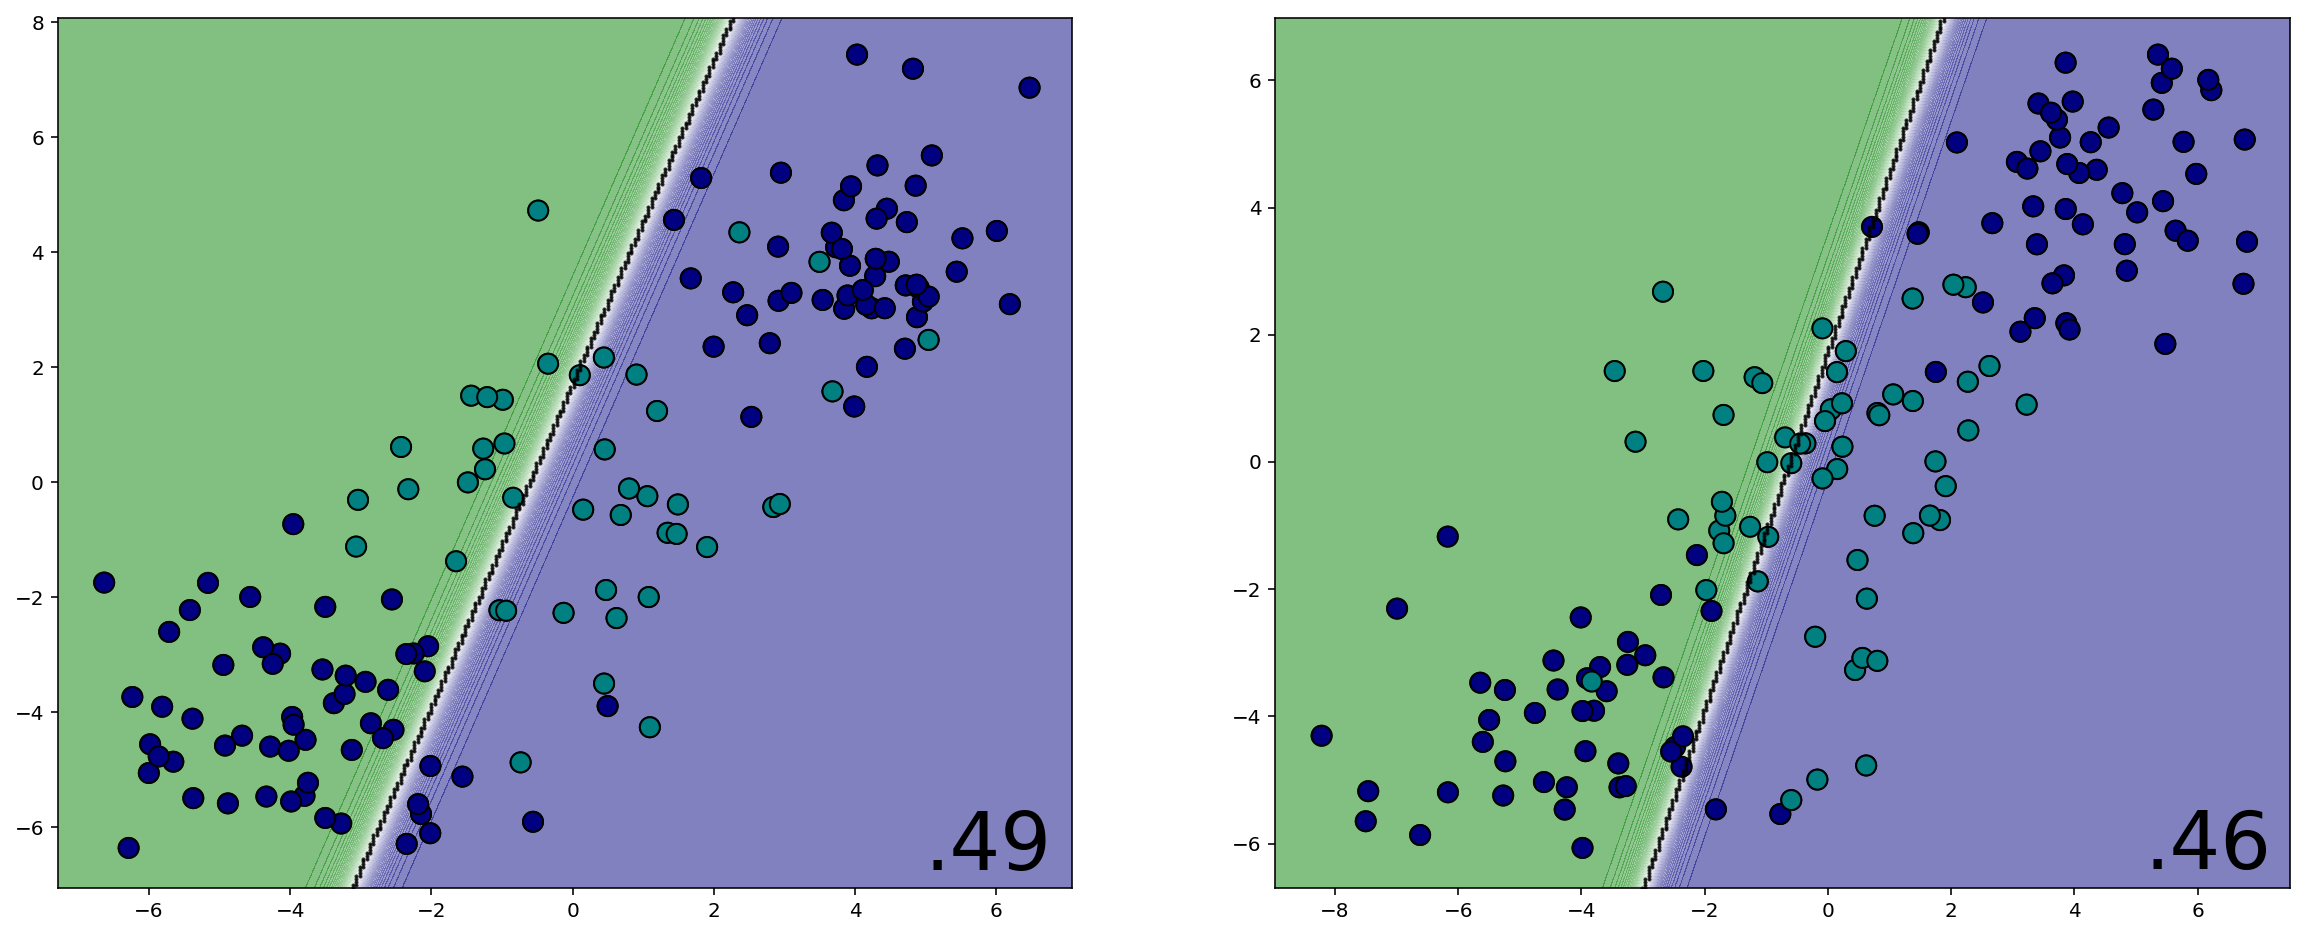

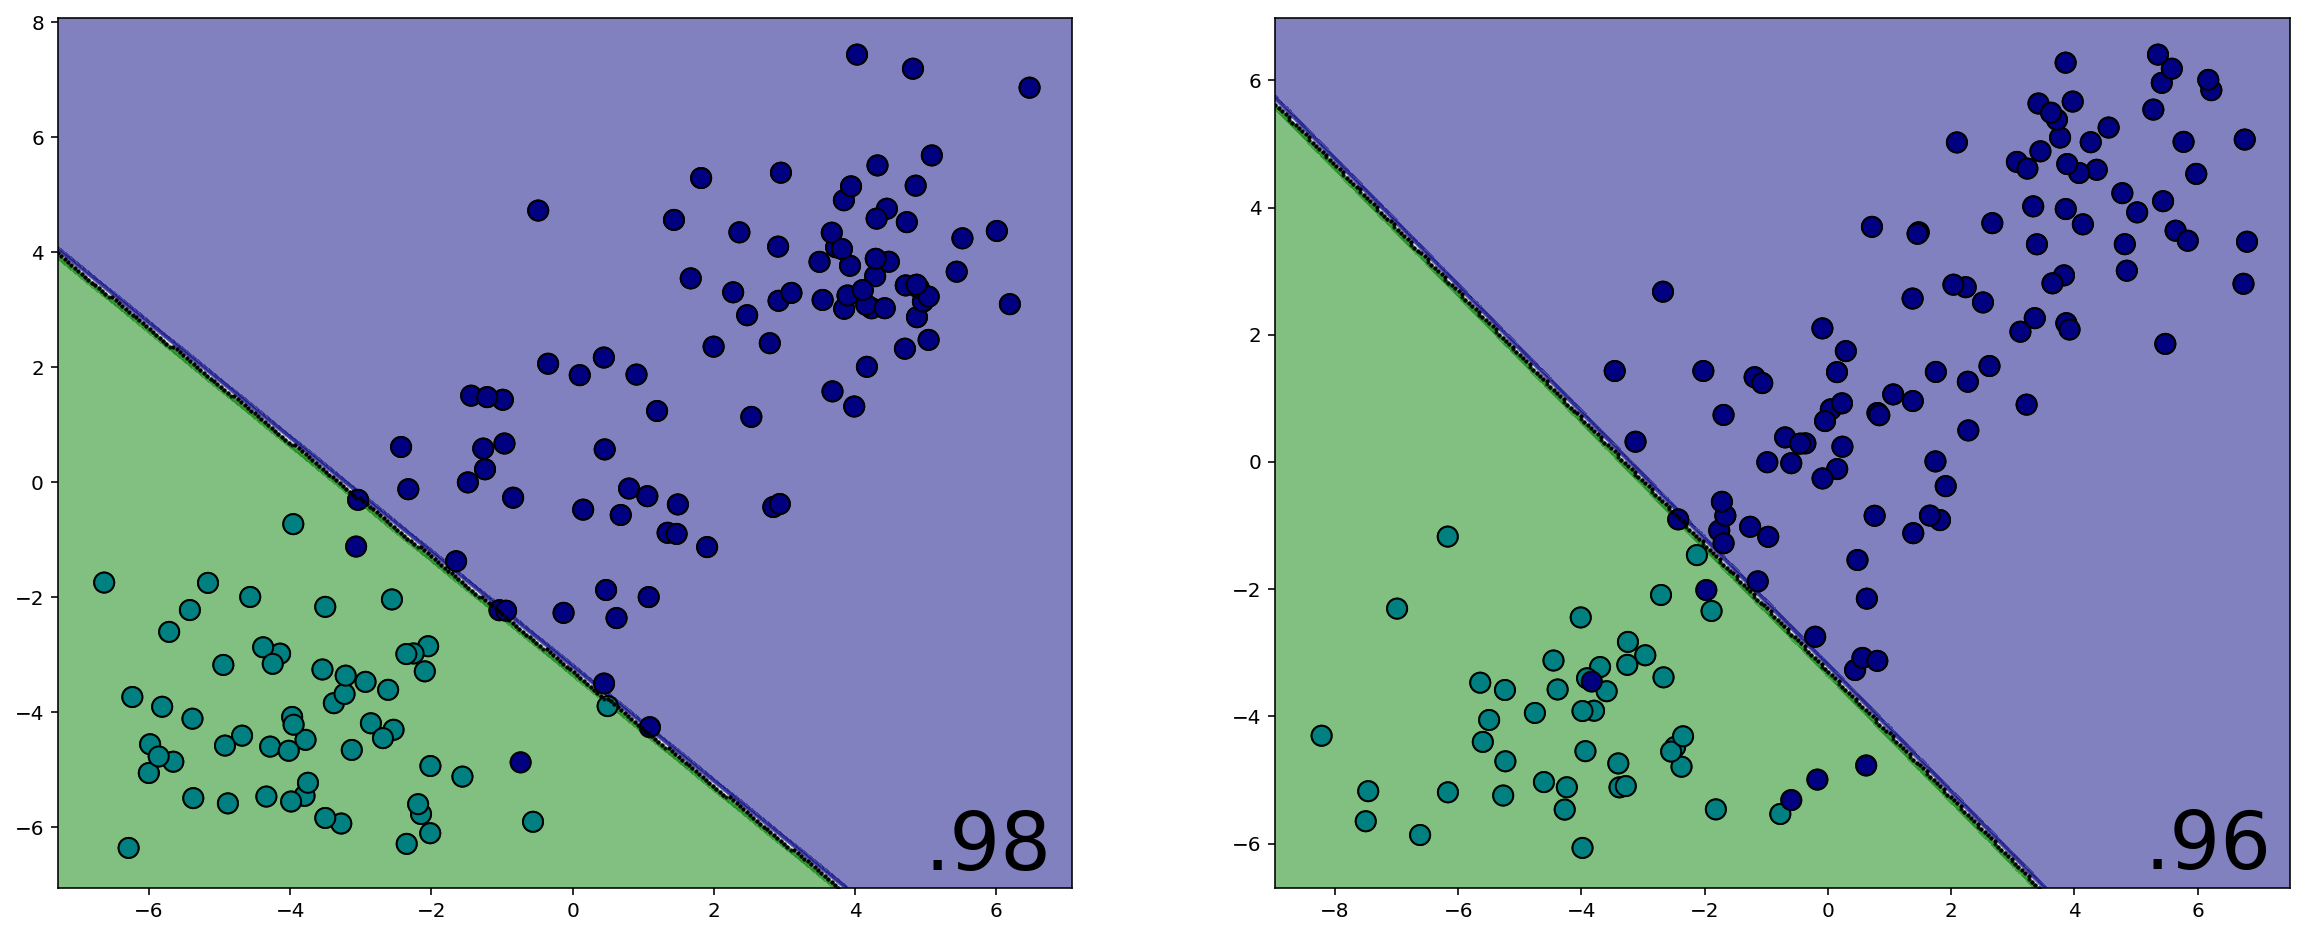

In [160]:
for rv_sel in range(y_train_cat.shape[1]):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
    score_train = models_vs_rest[rv_sel].score(X_train, y_train_cat[:,rv_sel])
    score_test = models_vs_rest[rv_sel].score(X_test, y_test_cat[:,rv_sel])
    MH.plot_MC_boundaries_sklearn(X_train, y_train_cat[:,rv_sel], score_train, models_vs_rest[rv_sel].predict_proba, normalize = False, ax=ax1)
    MH.plot_MC_boundaries_sklearn(X_test, y_test_cat[:,rv_sel], score_test, models_vs_rest[rv_sel].predict_proba, normalize = False, ax=ax2)
    plt.show()

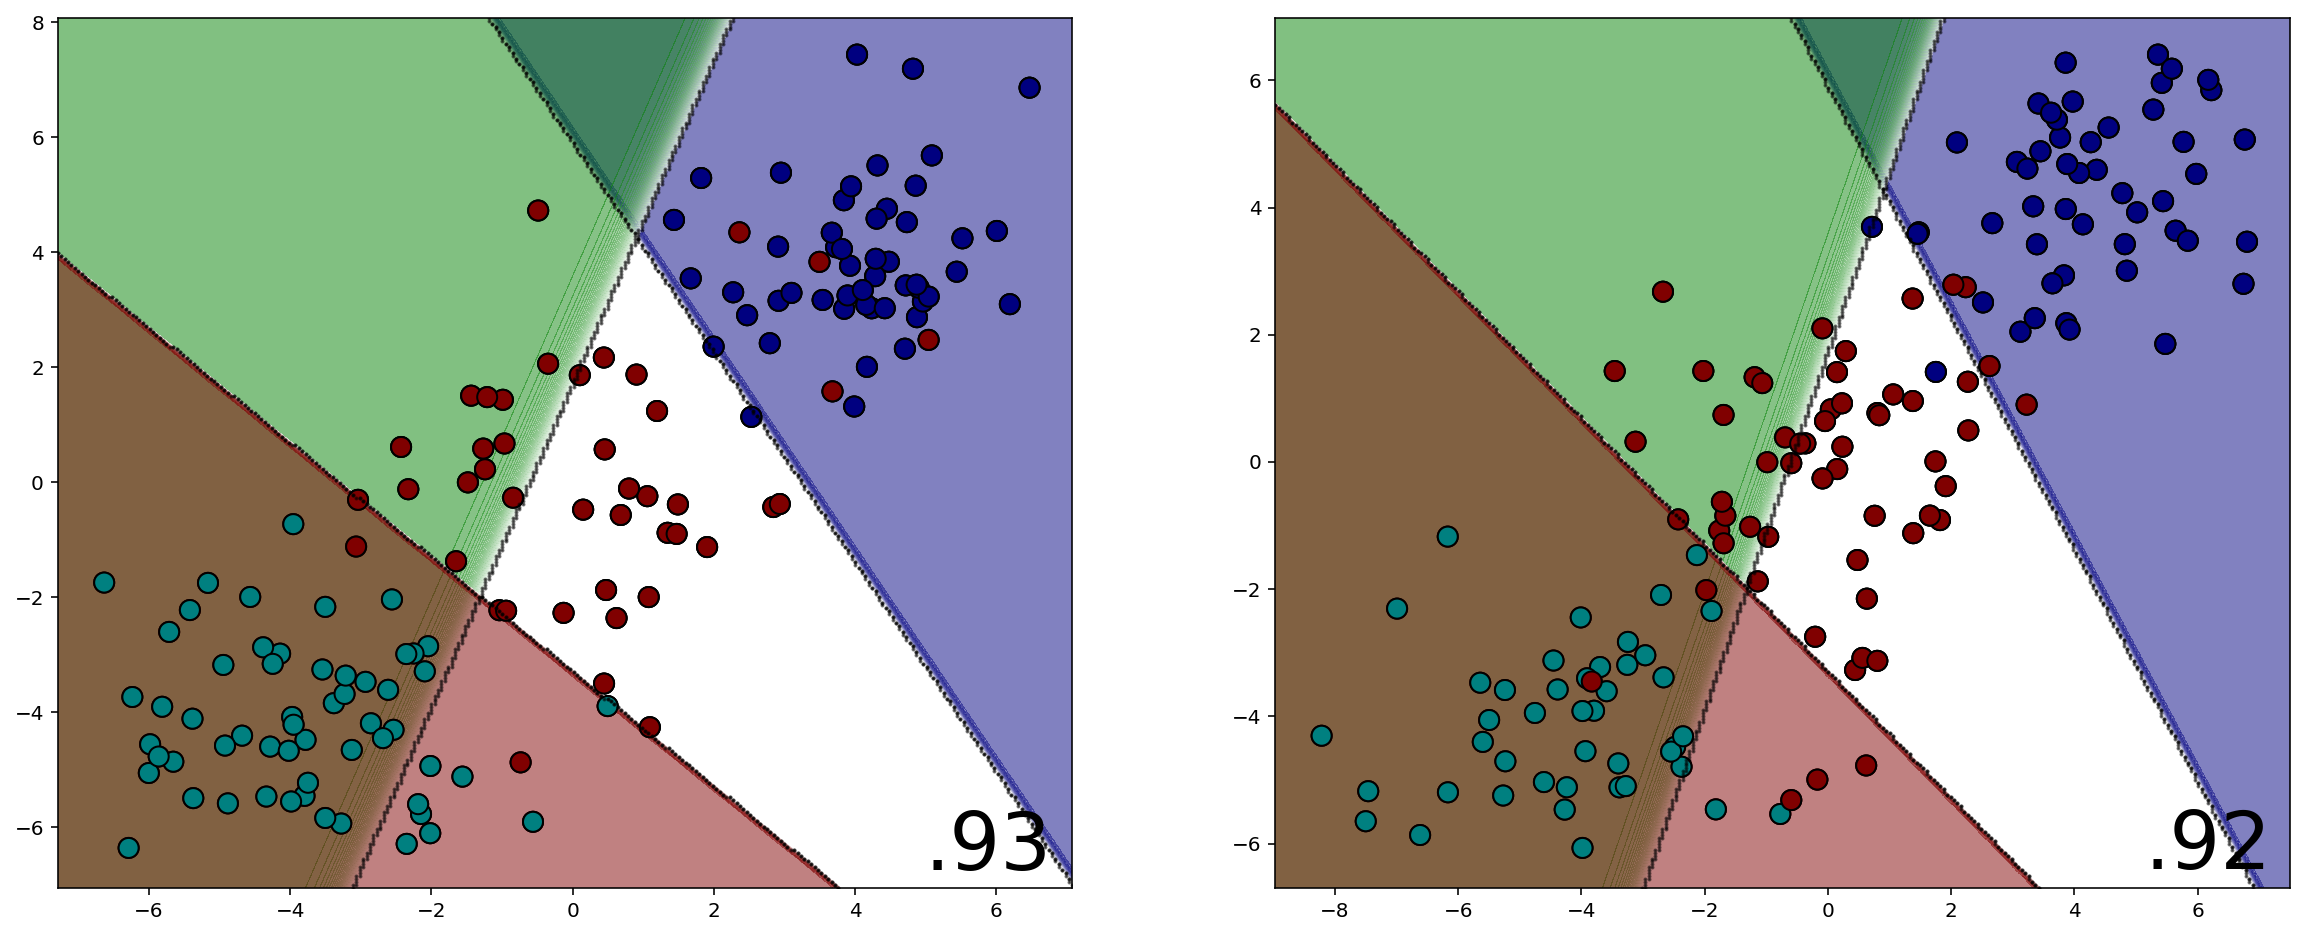

In [161]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
score_train = evaluate_proba_one_rest(X_train, y_train)
score_test = evaluate_proba_one_rest(X_test, y_test)
MH.plot_MC_boundaries_sklearn(X_train, y_train, score_train, predict_proba_one_rest, normalize = False,  ax=ax1)
MH.plot_MC_boundaries_sklearn(X_test, y_test, score_test, predict_proba_one_rest, normalize = False,  ax=ax2)
plt.show()

In [162]:
# Esta función calcula la P contra cada modelo y la devuleve como vector
print(np.round(predict_proba_one_rest(X_train, verbose=0)[:5]*100)/100)

[[0.   0.   0.99]
 [0.   0.   0.  ]
 [0.   0.99 1.  ]
 [1.   0.   0.  ]
 [0.   0.93 1.  ]]


In [163]:
# Verificamos que no suman 1 como es de esperar
print(predict_proba_one_rest(X_train, verbose=0)[:5].sum(axis=1))

[9.92295002e-01 5.30878235e-05 1.98804155e+00 1.00000000e+00
 1.92514372e+00]


### Graficamos superponiendo y normalizando

$\large \frac{p_j}{\sum_i{p_i}} = 0.5$

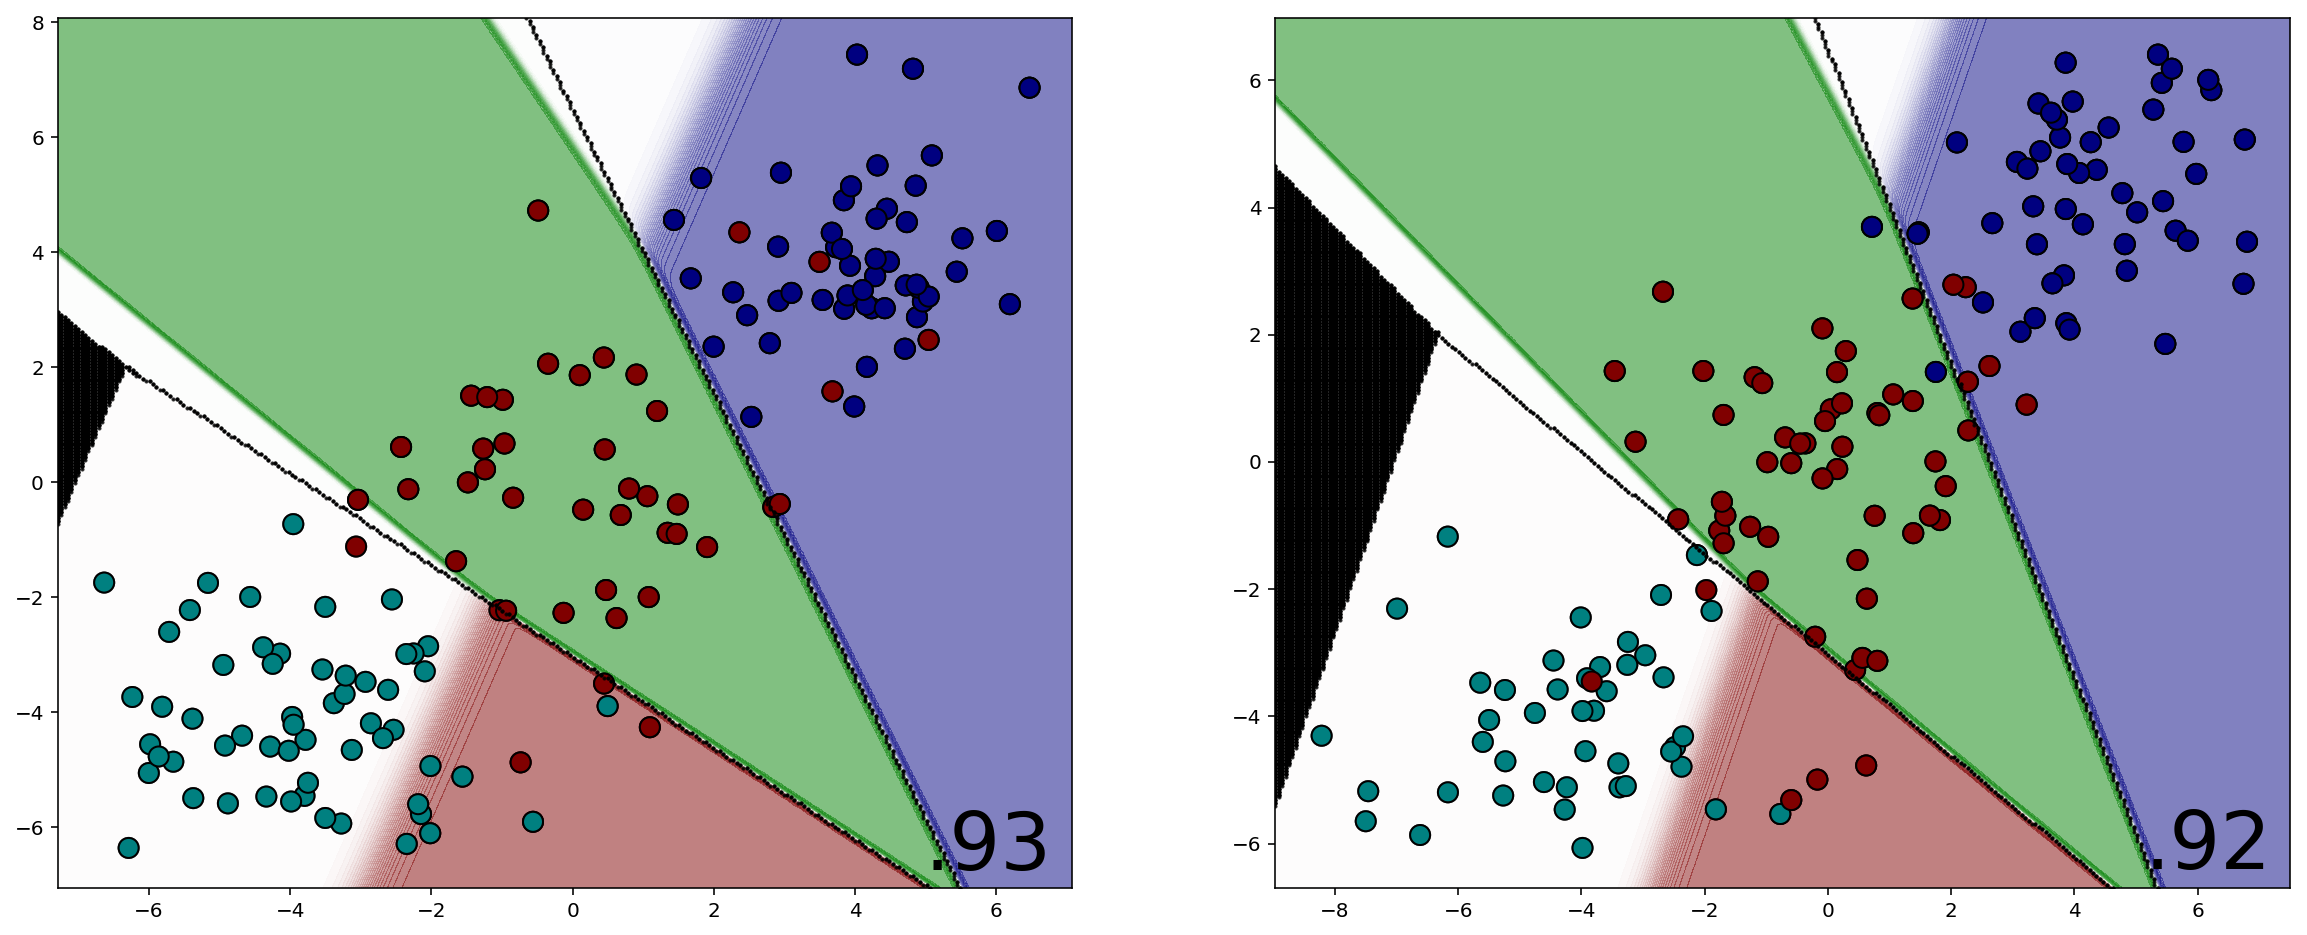

In [164]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
score_train = evaluate_proba_one_rest(X_train, y_train)
score_test = evaluate_proba_one_rest(X_test, y_test)
MH.plot_MC_boundaries_sklearn(X_train, y_train, score_train, predict_proba_one_rest, normalize = True,  ax=ax1)
MH.plot_MC_boundaries_sklearn(X_test, y_test, score_test, predict_proba_one_rest, normalize = True, ax=ax2)
plt.show()

### Grafico clases en el plano

$(X_1, X_2) \in C_j \iff \arg \max\limits_i(p_i) = j$

In [172]:
def predict_class_one_rest(X):
    out=enc.fit_transform(np.argmax(predict_proba_one_rest(X), axis=1).reshape(-1,1)).toarray()
    return out

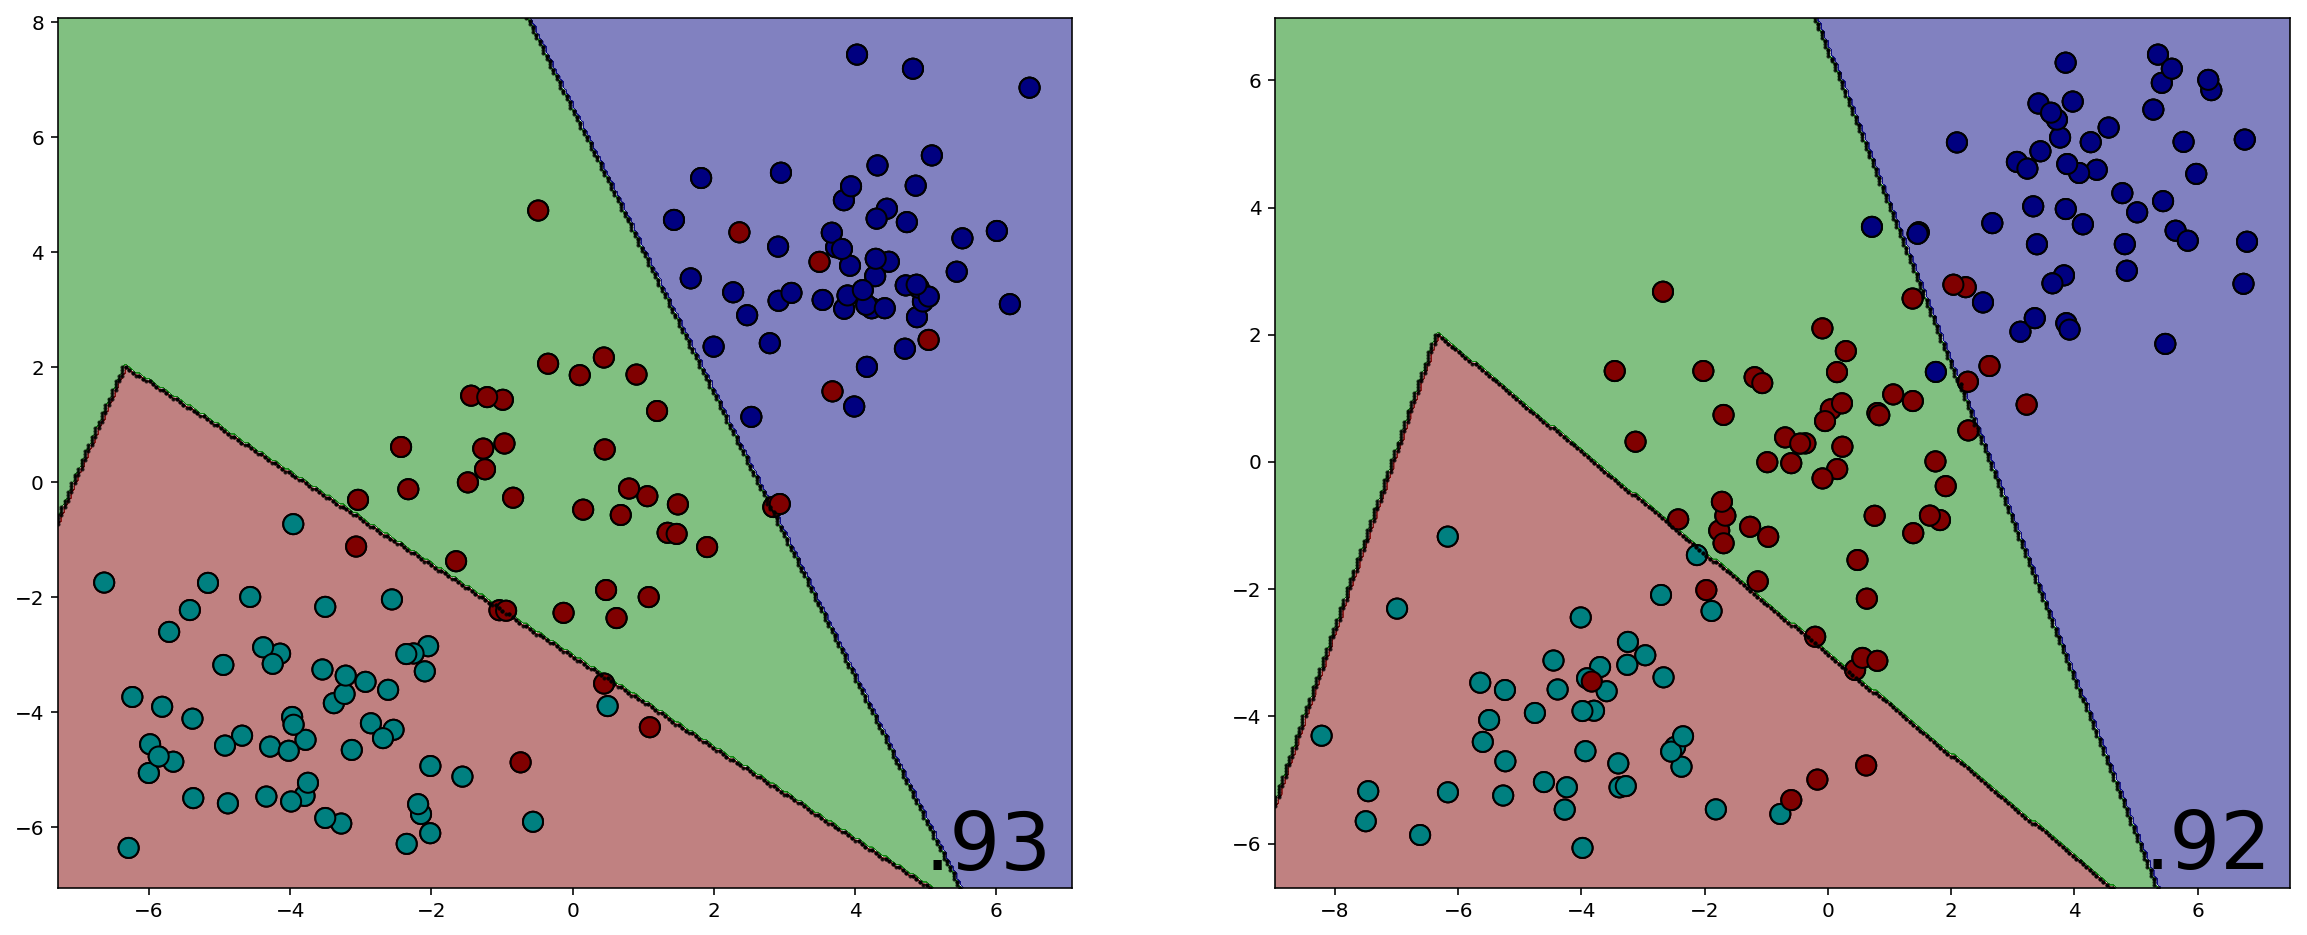

In [173]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
score_train = evaluate_proba_one_rest(X_train, y_train)
score_test = evaluate_proba_one_rest(X_test, y_test)
MH.plot_MC_boundaries_sklearn(X_train, y_train, score_train, predict_class_one_rest, normalize = False, ax=ax1)
MH.plot_MC_boundaries_sklearn(X_test, y_test, score_test, predict_class_one_rest, normalize = False,  ax=ax2)
plt.show()

# Modelo con Softmax

## Generalización de la función sigmoidea en la regresión logística

Para armar un modelo probabilístico con varias clases, podemos crear una función que tenga como requerimiento que el logodds entre cada par de clases sea lineal.
Veamos si se puede lograr esto intentando generalizar la sigmoidea. Un truco para definir la sigmoidea desde un concepto mas genérico es definir un score exponencial para cada una de las clases.

$$ P_u (Y=1|X) = \exp{(\vec \omega_1^T X + b_1)} $$

$$ P_u (Y=0|X) = \exp{(\vec \omega_0^T X + b_0)} $$

$P_u$ significa probabilidad no-normalizada.

Para obtener la probabilidad de cada clase, debemos normalizar los scores como:

$$ P (Y=1|X) = \frac{P_u (Y=1|X)}{P_u (Y=0|X)+P_u (Y=1|X)} =\frac{\exp{(\vec \omega_1^T X + b_1)}}{\exp{(\vec \omega_0^T X + b_0)}+\exp{(\vec \omega_1^T X + b_1)}} = \frac{1}{1+\exp{(\vec{(\omega_0-\omega_1)}^T X + (b_0-b_1))}}  $$

Es decir, nos queda una sigmoidea de parámetros $\omega=\omega_0-\omega_1$ y $b=b_0-b_1$. Por lo tanto para el caso de dos clases, el logodds nos queda lineal.
La probabilidad de la otra clase la podemos calcular como:

$$ P (Y=0|X) = \frac{P_u (Y=0|X)}{P_u (Y=0|X)+P_u (Y=1|X)} = 1 - P (Y=1|X) $$

Para el caso de K clases, podemos ampliar esta definición, y nos queda para la clase k:

$$ P_u (Y=k|X) = \exp{(\vec \omega_k^T X + b_k)} $$

Normalizando para obtener las probabilidades, nos queda:

$$ P_u (Y=k|X) = \frac{\exp{(\vec \omega_k^T X + b_k)}}{\sum_{i=1}^K{\exp{(\vec \omega_i^T X + b_i)}}} $$

Por lo tanto, el odds entre dos clases k y l nos queda:

$$odds(k,l)=\frac{1}{1+\exp{(\vec{(\omega_l-\omega_k)}^T X + (b_l-b_k))}}$$

y por lo tanto el logodds nos queda:

$$ logodds(k,l)= \log \frac{\exp{(\vec \omega_k^T X + b_k)}}{\exp{(\vec \omega_l^T X + b_l)}} = \vec{(\omega_k-\omega_l)}^T X + (b_k-b_l)$$

Por lo que el logodds entre todas los pares de clases nos queda lineal.

### Función softmax

En el caso presentado recientemente se definió el score:

$$P_u (Y=k|X)= \exp({h_k(X)})$$

Se define la función softmax como una función que mapea $\mathbb{R}^K \rightarrow \mathbb{R}^K$ de la siguiente forma:

$$\left[h_1,h_2,...,h_K \right] => \left[\frac{\exp(h_1)}{\sum_{i=0}^K{\exp(h_i)}},\frac{\exp(h_2)}{\sum_{i=0}^K{\exp(h_i)}} , ... , \frac{\exp(h_K)}{\sum_{i=0}^K{\exp(h_i)}}\right]$$

La función softmax recibe K valores de probabilidad no normalizada (en la regresión logística los scores exponenciales) y devuelve el valor de probabilidad de cada clase.

## Regresión Softmax o Regresión Logística Multiclase

Teniendo en cuenta lo anterior, tenemos un set de pesos para cada salida. Gráficamente nos queda:

<img src="softmax_nn.png">


### Función de costo

Si recordamos el siguiente diagrama:

<img src="Regre.jpg">

Podemos escribir el Likelihood de este modelo como:

$$\mathcal{L}=\prod_{i=1}^N \prod_{l=1}^K P(y_i=l|X_i) ^ {d_{i,l}}$$

donde $d_i$ es el one hot vector de la clase de la observación $i$-ésima y $d_{i,l}$ es la componente $l$-ésima de ese one hot vector. Para cada observación solo sobrevivirá una de las probabilidades, la cual corresponde con la clase que está anotada como verdadera.

Cuando utilizamos optimizadores en vez de maximizar el likelihood, nuevamente minimizamos $-\log \mathcal{L} = categorical\_xent$

$$categorical\_xent=-\sum_{i=1}^N \sum_{l=1}^K d_{i,l}.\log P(y_i=l|X_i)=-\sum_{i=1}^N \sum_{l=1}^K d_{i,l}.\log \frac{\exp(h_l)}{\sum_{m=0}^K{\exp(h_m)}}$$

Si analizamos la ecuación anterior veremos que las operaciones que unen a la $categorical\_xent$ con los parámetros del modelo son todas derivables, por lo tanto podemos utilizar los métodos de optimización que vimos anteriormente para encontrar el mínimo de la función de costo.

Para debatir en clase:

* ¿Cuántos términos sobreviven de la sumatoria en $l$ para cada observación?
* ¿Cómo es la complejidad para cada iteración del entrenamiento?
* ¿Si se aplica la regla de la cadena para calcular el gradiente de la función de costo, cómo se propaga dicho gradiente en el diagrama de la softmax?

Volvemos a poner el diagrama para seguirlo con mayor facilidad:

<img src="softmax_nn.png">

### Ejercicio

Escribir la derivada parcial de la $categorical_xent$ en función del parámetro $w_{1,1}$ aplicando la regla de la cadena.

In [175]:
X_train.shape

(150, 2)

In [196]:
clf = SGDClassifier(max_iter=100000, tol=1e-9,loss='log')
clf.fit(X_train, y_train)
clf.score(X_test,y_test)

0.92

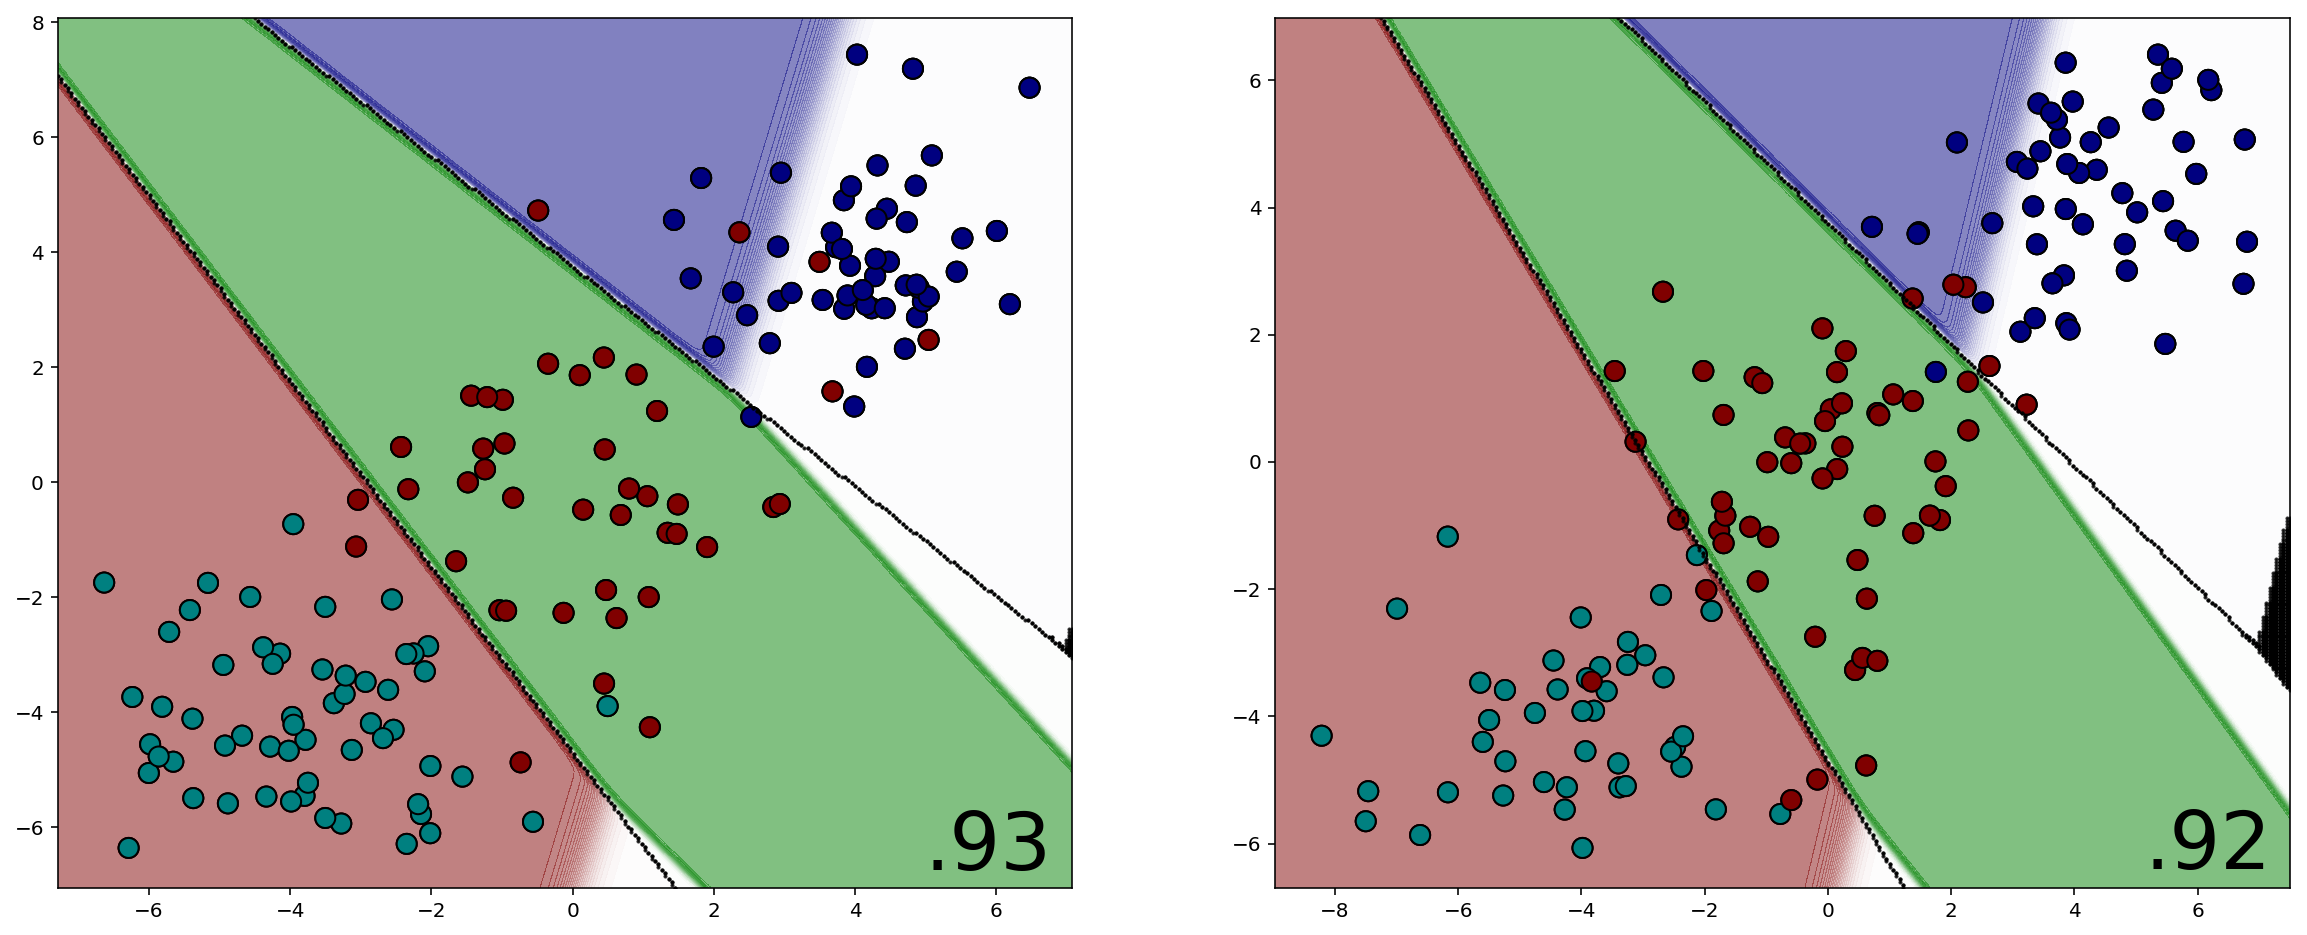

In [197]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
score_train = clf.score(X_train,y_train)
score_test = clf.score(X_test,y_test)
MH.plot_MC_boundaries_sklearn(X_train, y_train, score_train, clf.predict_proba, normalize = False,  ax=ax1)
MH.plot_MC_boundaries_sklearn(X_test, y_test, score_test, clf.predict_proba, normalize = False, ax=ax2)
plt.show()